In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
dataset_dir = 'location_to_the_dataset'

# Create an ImageDataGenerator for loading and preprocessing images
image_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

image_height = 224
image_width = 224
batch_size = 16


# Load images from the directory
fracture_dataset = image_datagen.flow_from_directory(
    dataset_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='input'
)

In [ ]:
# Calculate the number of steps per epoch
num_samples = fracture_dataset.samples
num_steps_per_epoch = int(np.ceil(num_samples / batch_size))

# Create train and test splits
x_train = []
for _ in range(num_steps_per_epoch):
    images, _ = fracture_dataset.next()
    x_train.extend(images)

# Convert to numpy array
x_train = np.array(x_train)

# Split train and test sets
split_ratio = 0.8  # 80% train, 20% test
split_index = int(split_ratio * len(x_train))
x_train, x_test = x_train[:split_index], x_train[split_index:]

# Convert pixel values to [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Display the shape of the datasets
print("Shape of train set:", x_train.shape)
print("Shape of test set:", x_test.shape)

Shape of train set: (7098, 224, 224, 1)
Shape of test set: (1775, 224, 224, 1)


In [ ]:
x_train.shape, x_test.shape

((7098, 224, 224, 1), (1775, 224, 224, 1))

In [ ]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (7, 7), activation='relu', padding='valid')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (7, 7), activation='relu', padding='valid'),
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', strides=2)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
# Instantiate the model
model = Autoencoder()

# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
criterion = tf.keras.losses.MeanSquaredError()

In [ ]:
# Training loop
epochs = 4
batch_size = 16
num_batches = x_train.shape[0] // batch_size
loss_values = []

In [ ]:
# Training
for epoch in range(epochs):
    for batch in range(num_batches):
        x_batch = x_train[batch * batch_size: (batch + 1) * batch_size]
        with tf.GradientTape() as tape:
            _ , reconstructed = model(x_batch, training=True)
            # Remove the extra dimension from the target data
            x_batch = tf.squeeze(x_batch, axis=-1)
            loss = criterion(x_batch, reconstructed)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_values.append(loss)
    print(f'Epoch:{epoch+1}, Loss:{loss.numpy():.4f}')

Epoch:1, Loss:0.0014
Epoch:2, Loss:0.0008
Epoch:3, Loss:0.0005
Epoch:4, Loss:0.0004


In [ ]:
model.save_weights('location_to_the_weights')

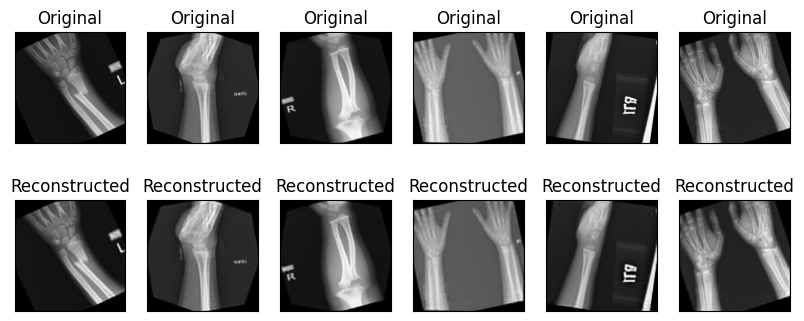

In [ ]:
# Display sample reconstructions
n = 6
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(x_test[i], axis=-1), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    # Get the reconstructed image from the model output
    encoded, reconstructed_img = model(x_test[i:i+1])
    # Remove the singleton dimension before plotting
    plt.imshow(tf.squeeze(reconstructed_img, axis=0), cmap='gray')
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print(reconstructed_img.shape)

(1, 224, 224, 1)
